In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
from aux_plotting import applyPlotStyle
from aux_feature_importances import getAUC, getImpVec, getLabels, formatLabels
import seaborn as sns

### WARNING: 
Please make sure you generate the leave-one-out models before running this notebook. They are required to calculate feature importances.

In [3]:
applyPlotStyle()

In [4]:
settings = {}
settings['train_parent_folder'] = '../trained_models/results_submission_20200916_100417'
settings['train_loo_folder'] = '../trained_models/leaveOneOut_results_submission_XXXXXXXX_YYYYYY'

output_folder = 'graphs-files'

In [5]:
her2='agnost'
feats='chemo'
rcut = 0.8
df_labels_agnost = getLabels()

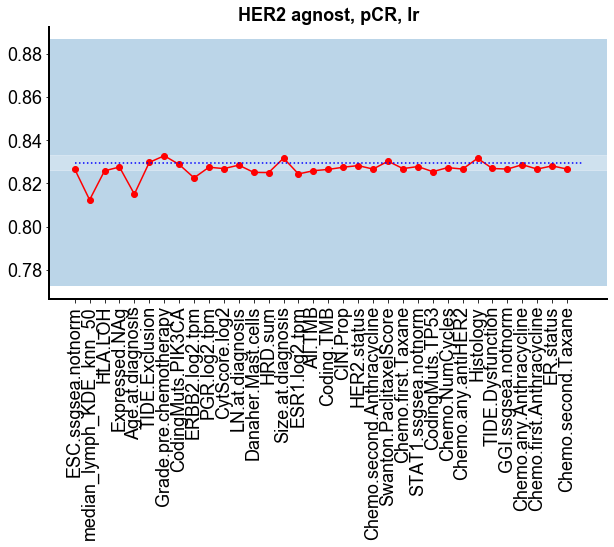

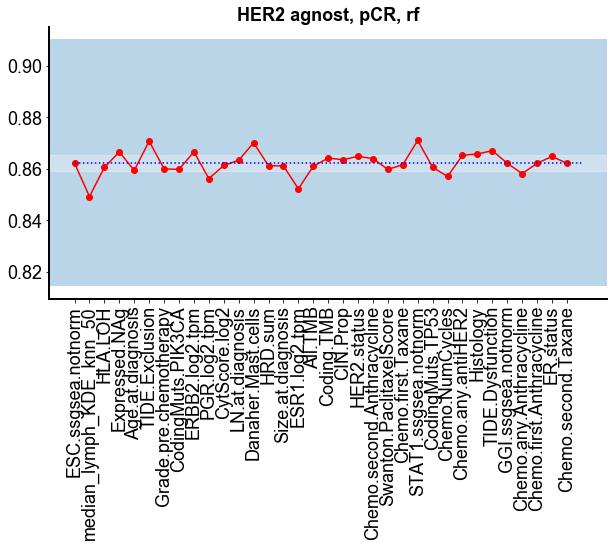

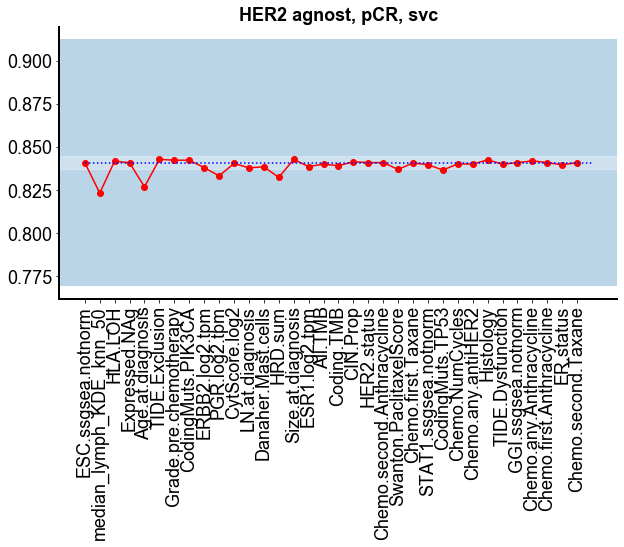

In [6]:
#df_labels_agnost['pCR'] = getImpVec(her2, rcut, feats, df_labels_agnost, settings)
lr_z, lr_feat, lr_s, rf_z, rf_feat, rf_s, svc_z, svc_feat, svc_s = getImpVec(her2, rcut, feats, df_labels_agnost, settings)

## Signless differences:

In [7]:
def sortZs(ref, cat, z):
    res = [tuple for x in ref for tuple in zip(cat,z) if tuple[0] == x] 
    return [x[1] for x in res]

In [8]:
top_lr = np.array([1 if (x in lr_feat[lr_z>=1]) else 0 for x in df_labels_agnost['Classification'].values])
top_rf = np.array([1 if (x in rf_feat[rf_z>=1]) else 0 for x in df_labels_agnost['Classification'].values])
top_svc = np.array([1 if (x in svc_feat[svc_z>=1]) else 0 for x in df_labels_agnost['Classification'].values])

In [9]:
imp_vec = (top_lr+top_rf+top_svc).astype(float)
imp_sel = np.array([0 if ((x in lr_feat[lr_z>0]) or (x in rf_feat[rf_z>0]) or (x in svc_feat[svc_z>0])) else 0 for x in df_labels_agnost['Classification'].values])
imp_vec[imp_vec==0] = imp_sel[imp_vec==0]

In [10]:
df_labels_agnost['pCR'] = imp_vec
df_labels_agnost['lr'] = top_lr
df_labels_agnost['rf'] = top_rf
df_labels_agnost['svc'] = top_svc
df_labels_agnost['lr_cont'] = sortZs(df_labels_agnost['Classification'].values, lr_feat, lr_z)
df_labels_agnost['rf_cont'] = sortZs(df_labels_agnost['Classification'].values, rf_feat, rf_z)
df_labels_agnost['svc_cont'] = sortZs(df_labels_agnost['Classification'].values, svc_feat, svc_z)
df_labels_agnost['lr_scont'] = sortZs(df_labels_agnost['Classification'].values, lr_feat, lr_s)
df_labels_agnost['rf_scont'] = sortZs(df_labels_agnost['Classification'].values, rf_feat, rf_s)
df_labels_agnost['svc_scont'] = sortZs(df_labels_agnost['Classification'].values, svc_feat, svc_s)


df_labels_agnost = formatLabels(df_labels_agnost)

In [11]:
# Create custom colormap
import matplotlib as mpl
cmaplist = np.array([[255, 255, 255],[171, 189, 217],[60, 196, 246],[22, 96, 136]])/255
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, 4)

### Summarise treatment rows

In [12]:
### Summarise the treatment rows
therapy_sequence = df_labels_agnost[28:32].mean()
df_labels_agnost_summ = df_labels_agnost.append(therapy_sequence, ignore_index=True)
df_labels_agnost_summ.iloc[-1,0] = 'Treatment'
df_labels_agnost_summ.iloc[-1,1] = 'Treatment'
df_labels_agnost_summ.iloc[-1,3] = 'Therapy sequence'

## And drop the previous ones
df_labels_agnost_summ.drop([28,29,30,31], inplace=True)

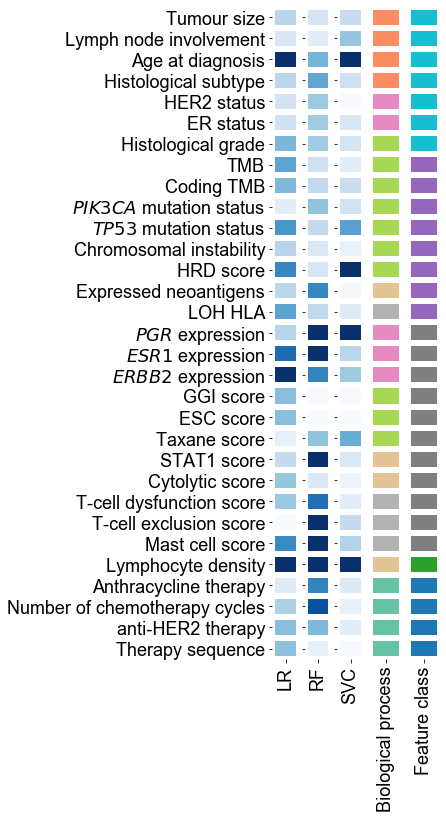

In [13]:
# Create figure
fig, ax = plt.subplots(1,5,gridspec_kw={'width_ratios': [1, 1, 1, 1.2, 1.2]},figsize=(3,12))
fig.subplots_adjust(hspace=0.00)

sns.heatmap(df_labels_agnost_summ[['lr_cont']], linewidths=5, cmap='Blues', ax=ax[0], cbar=False, vmax=2)
ax[0].set_xticklabels(['LR'], rotation=90)
ax[0].set_yticklabels(df_labels_agnost_summ['Label'], rotation=0)

sns.heatmap(df_labels_agnost_summ[['rf_cont']], linewidths=5, cmap='Blues', ax=ax[1], cbar=False, vmax=2)
ax[1].set_xticklabels(['RF'], rotation=90)
ax[1].set_yticklabels([])

sns.heatmap(df_labels_agnost_summ[['svc_cont']], linewidths=5, cmap='Blues', ax=ax[2], cbar=False, vmax=2)
ax[2].set_xticklabels(['SVC'], rotation=90)
ax[2].set_yticklabels([])

sns.heatmap(df_labels_agnost_summ[['ClassNum']], linewidths=5, cmap='Set2', ax=ax[3], cbar=False)
ax[3].set_xticklabels(['Biological process'], rotation=90)
ax[3].set_yticks([])

sns.heatmap(df_labels_agnost_summ[['DataNum']], linewidths=5, cmap='tab10_r', ax=ax[4], cbar=False)
ax[4].set_xticklabels(['Feature class'], rotation=90)
ax[4].set_yticks([])

plt.savefig(output_folder+'/summary_feat_import_unsigned_3algos.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Average out the three algorithms

In [14]:
mean_cont = df_labels_agnost_summ.loc[:,['lr_cont','rf_cont','svc_cont']].mean(axis=1)
df_labels_agnost_summ['mean_cont'] = mean_cont

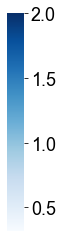

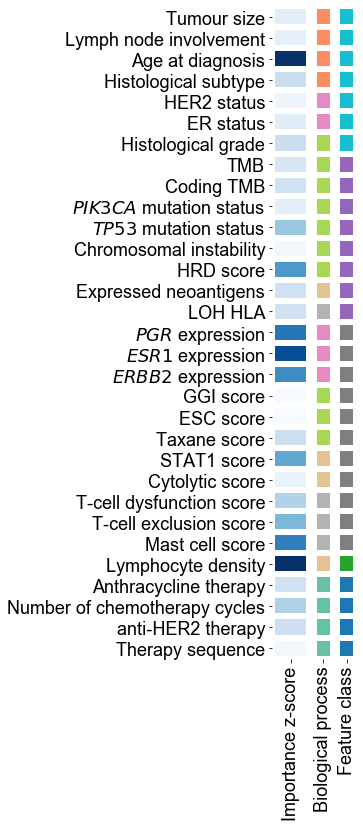

In [15]:
# Colorbar
cbar_f, cbar_ax = plt.subplots(1,1,figsize=(0.3,4))
cbar_ax.set_xticks([])

# Main figure
fig, ax = plt.subplots(1,3,gridspec_kw={'width_ratios': [1, 0.5, 0.5]},figsize=(1.5,12))
fig.subplots_adjust(hspace=0.00)

sns.heatmap(df_labels_agnost_summ[['mean_cont']], linewidths=5, cmap='Blues', ax=ax[0], cbar=True, vmax=2, cbar_ax=cbar_ax)
ax[0].set_xticklabels(['Importance z-score'], rotation=90)
ax[0].set_yticklabels(df_labels_agnost_summ['Label'], rotation=0)

sns.heatmap(df_labels_agnost_summ[['ClassNum']], linewidths=5, cmap='Set2', ax=ax[1], cbar=False)
ax[1].set_xticklabels(['Biological process'], rotation=90)
ax[1].set_yticks([])

sns.heatmap(df_labels_agnost_summ[['DataNum']], linewidths=5, cmap='tab10_r', ax=ax[2], cbar=False)
ax[2].set_xticklabels(['Feature class'], rotation=90)
ax[2].set_yticks([])

cbar_f.savefig(output_folder+'/summary_feat_import_unsigned_averaged_colorbar.pdf', bbox_inches='tight', transparent=True)
fig.savefig(output_folder+'/summary_feat_import_unsigned_averaged.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Signed importances

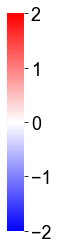

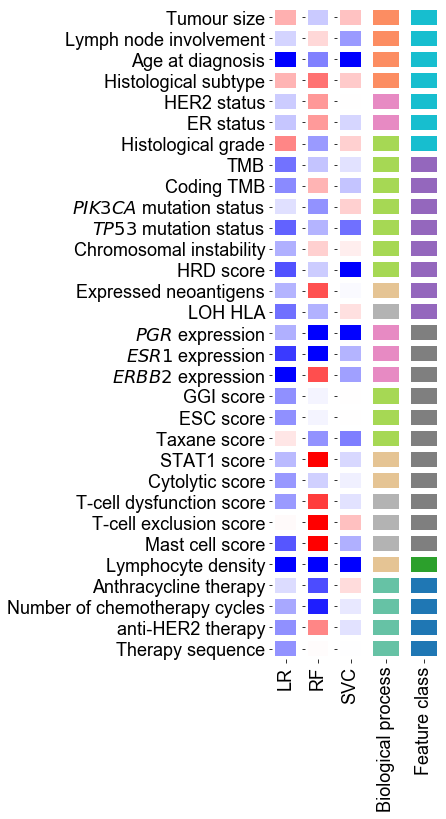

In [16]:
# Colorbar
cbar_f, cbar_ax = plt.subplots(1,1,figsize=(0.3,4))
cbar_ax.set_xticks([])

# Create figure
fig, ax = plt.subplots(1,5,gridspec_kw={'width_ratios': [1, 1, 1, 1.2, 1.2]},figsize=(3,12))
fig.subplots_adjust(hspace=0.00)

sns.heatmap(df_labels_agnost_summ[['lr_scont']], linewidths=5, cmap='bwr', ax=ax[0], cbar=True, cbar_ax=cbar_ax, vmax=2, vmin=-2)
ax[0].set_xticklabels(['LR'], rotation=90)
ax[0].set_yticklabels(df_labels_agnost_summ['Label'], rotation=0)

sns.heatmap(df_labels_agnost_summ[['rf_scont']], linewidths=5, cmap='bwr', ax=ax[1], cbar=False, vmax=2, vmin=-2)
ax[1].set_xticklabels(['RF'], rotation=90)
ax[1].set_yticklabels([])

sns.heatmap(df_labels_agnost_summ[['svc_scont']], linewidths=5, cmap='bwr', ax=ax[2], cbar=False, vmax=2, vmin=-2)
ax[2].set_xticklabels(['SVC'], rotation=90)
ax[2].set_yticklabels([])

sns.heatmap(df_labels_agnost_summ[['ClassNum']], linewidths=5, cmap='Set2', ax=ax[3], cbar=False)
ax[3].set_xticklabels(['Biological process'], rotation=90)
ax[3].set_yticks([])

sns.heatmap(df_labels_agnost_summ[['DataNum']], linewidths=5, cmap='tab10_r', ax=ax[4], cbar=False)
ax[4].set_xticklabels(['Feature class'], rotation=90)
ax[4].set_yticks([])

cbar_f.savefig(output_folder+'/summary_feat_import_signed_3algos_colorbar.pdf', bbox_inches='tight', transparent=True)
fig.savefig(output_folder+'/summary_feat_import_signed_3algos.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()